In [29]:
%load_ext autoreload
%autoreload 2

#Misc
import time, os, sys, pdb
from glob import glob
from fnmatch import fnmatch

#Base
import numpy as np
import pandas as pd
import scipy.stats as st
import multiprocessing as mp

#Save
import json, h5py
import scipy.io as sio
import io_dict_to_hdf5 as ioh5

#Plot
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages

#User
import util
import plotting as usrplt
import decoding as dc

success_dict = {0: 'incorrect',1: 'correct', 2: 'abort'}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#Read in cross-validation parameters
# BaseDir = './results/sticky-ARHMM_lag-1_dsf-2_kappa-1e+07_2020-11-15_1437'
BaseDir = '/srv/data/data0/dwyrick/projects/jumping_behavior/results/Last_5s/sticky-ARHMM_lag-1_dsf-2_kappa-1e+04_2021-04-04_2033'
with open(os.path.join(BaseDir,'ARHMM_hyperparameters.json')) as json_file:
    opt = json.load(json_file)
opt

{'save': 1,
 'RootDataDir': '/gpfs/projects/niell/nlab/Jumping/ARHMM/data/',
 'ResultsDir': '/gpfs/projects/niell/nlab/Jumping/ARHMM/results',
 'mID': 'all_mice',
 'downsample_factor': 2,
 'model_type': 'ARHMM',
 'transitions': 'sticky',
 'observations': 'autoregressive',
 'inputdriven': 0,
 'Kmin': 13,
 'Kmax': 16,
 'kappa': 10000.0,
 'AR_lags': 1,
 'MAP_threshold': 0.75,
 'EM_tolerance': 1e-06,
 'EM_iters': 200,
 'xval_type': 'K',
 'kXval': 2,
 'max_processes': 7,
 'SaveDirRoot': '/gpfs/projects/niell/nlab/Jumping/ARHMM/results/sticky-ARHMM_lag-1_dsf-2_kappa-1e+04_2021-04-04_2033',
 'cut': 5}

In [3]:
Ks = np.arange(6,17)
Ks

array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

In [4]:
ll_heldout = np.zeros((len(Ks),3),dtype=np.float64)
BIC_heldout = np.zeros((len(Ks),3),dtype=np.float64)
obs_dim = 6
for jj, K in enumerate(Ks):
    # Initial state distribution + A matrices + B matrices + covariance + transition probability matrix
    num_parameters = K + K*obs_dim*obs_dim + K*obs_dim + K*obs_dim*obs_dim + K*K
    print('{:02d}: '.format(K))
    KDir = os.path.join(BaseDir,'K-{:02d}'.format(K))

    #Get full model cross-validation
    fpath = glob(os.path.join(KDir,'fit_parameters*.h5'))[0]
    data = ioh5.load(fpath)
    tTest = data['tTest']; tTrain = data['tTrain']
    ll = data['ll_heldout']

    #Calculate number of timepoints 
    nTest = tTest*obs_dim; nTrain = tTrain*obs_dim
    ll_heldout[jj,-1] = ll/nTest

    #Calculate BIC
    BIC_heldout[jj,-1] = num_parameters*np.log(nTest) - 2*ll

    kfold_dirs = sorted(glob(os.path.join(KDir,'kFold_*')))
    for kk,kfold in enumerate(kfold_dirs):
        fpath = glob(os.path.join(kfold,'fit_parameters*.h5'))[0]
        data = ioh5.load(fpath)

        tTest = data['tTest']; tTrain = data['tTrain']
        ll = data['ll_heldout']
#         print('\t{}: {}\t{}'.format(kk,tTest,tTrain))

        #Calculate number of timepoints 
        nTest = tTest; nTrain = tTrain

        ll_heldout[jj,kk] = ll/nTest
        #Calculate BIC
        BIC_heldout[jj,kk] = num_parameters*np.log(nTest) - 2*ll

06: 


/home/dwyrick/projects/jumping_behavior/io_dict_to_hdf5.py:66: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  ans[key] = item.value


07: 
08: 
09: 
10: 
11: 
12: 
13: 
14: 
15: 
16: 


In [74]:
#Stratify data per mice and per condition for kfolds
from sklearn.model_selection import StratifiedKFold
k_fold = StratifiedKFold(n_splits=2)
include = ['{}_D{}'.format(i,j) for i,j in zip(list(data_df['subject']),list(data_df['distance']))]
for iK, (train_indices, test_indices) in enumerate(k_fold.split(data_list,include)):
    data_train = [data_list[ii] for ii in train_indices]    
    data_test = [data_list[ii] for ii in test_indices]
        
    tTest = sum(map(len, data_test))
    tTrain = sum(map(len, data_train))
    print('\t{}: {}\t{}'.format(iK,tTest,tTrain))

	0: 281677	279780
	1: 279780	281677


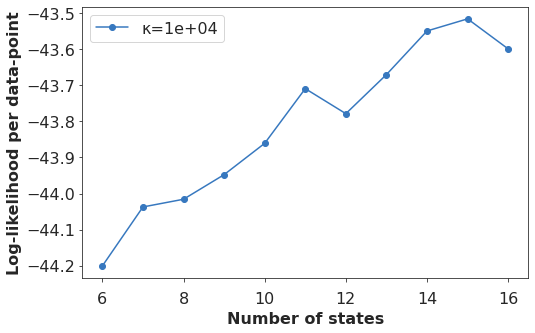

In [83]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(Ks,np.mean(ll_heldout[:,:-1],axis=-1),'o-',color=usrplt.cc[0],label='\u03BA={:.0e}'.format(opt['kappa']))
ax.set_xlabel('Number of states'); ax.set_ylabel('Log-likelihood per data-point')
ax.legend()
plt.savefig('./plots/ll_eabe.png')

In [5]:
data_list1, mask_list1, data_df1 = util.read_data('./data/variable_platform_data.h5',dsf=opt['downsample_factor'])
data_list2, mask_list2, data_df2 = util.read_data('./data/single_platform_data.h5',dsf=opt['downsample_factor'])

#Combine data
data_list = np.concatenate((data_list1,data_list2))
data_df = pd.concat((data_df1,data_df2)).reset_index()

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
##===== Read in data at downsample factor =====##
data_list, mask_list, data_df = util.read_data(dsf=opt['downsample_factor'])

##===== Read in data at downsample factor =====##
data_fullres_list, _, _ = util.read_data(dsf=1)

In [6]:
#Set abort trials to failure trials
# data_df.loc[data_df['success'] == 2,'success'] = 0

#Set "opto suture" trials where there was no optogenetics performed to "suture" trials
data_df.loc[(data_df['laser_trial'] == 'laser off') & (data_df['condition'] == 'opto suture'),'condition'] = 'suture'

#Print
data_df.head()

,index,expdate,subject,condition,platform,distance,jumpdist,success,laser_trial,jump_time,...,Side LEar y,Top LEar y,Side LEar likelihood,Top LEar likelihood,Side TakeFL x,Top TakeFL x,Side TakeFL y,Top TakeFL y,Side TakeFL likelihood,Top TakeFL likelihood
0,0,061920,J157BLT,control,2,8,-3.982283,2,laser off,125,...,"[423.72592347067524, 364.67165100973773, 305.6...","[408.64487500350447, 350.4616657749888, 292.19...","[0.9999992847442627, 0.9999996423721313, 0.999...","[0.9999997615814209, 0.9999998807907104, 0.999...","[343.8412719726563, 458.4371704101562, 573.033...","[314.5657470703125, 419.42099609375003, 524.27...","[447.1793585818351, 383.12674017363196, 319.07...","[399.84854478086413, 340.8283665582079, 281.80...","[0.999998927116394, 0.9999992847442627, 0.9999...","[0.022194653749465942, 0.013417750597000122, 0..."
1,1,061920,J157BLT,control,1,20,2.294397,2,laser off,222,...,"[431.3506579657288, 374.341929938385, 317.3332...","[408.56666509301635, 351.6943384328601, 294.74...","[0.9999973773956299, 0.9999958276748657, 0.999...","[0.9999992847442627, 0.9999996423721313, 0.999...","[343.52678222656255, 458.06650390625003, 572.6...","[312.7005615234375, 416.93408203125, 521.16760...","[445.4469291897769, 381.59209520540185, 317.73...","[402.9814164809759, 344.8621843032415, 286.742...","[0.9999996423721313, 0.9999996423721313, 0.999...","[0.04482194781303406, 0.06799852848052979, 0.0..."
2,2,061920,J157BLT,control,3,8,8.752227,1,laser off,355,...,"[404.79148060191767, 345.4358165394176, 286.00...","[358.79330694025214, 303.6803186590022, 248.71...","[0.9999998807907104, 0.9999998807907104, 0.999...","[0.9999997615814209, 0.9999997615814209, 0.999...","[343.5391479492188, 457.974072265625, 572.3549...","[314.574169921875, 419.43222656250003, 524.290...","[443.5941315622041, 379.59785470673535, 315.46...","[399.7992825594815, 341.9664090243253, 284.133...","[0.9999998807907104, 0.9999998211860657, 0.999...","[0.8656889796257019, 0.7850416302680969, 0.630..."
3,3,061920,J157BLT,control,1,12,11.868924,1,laser off,514,...,"[424.95687788606114, 367.8762260305924, 310.51...","[374.1019906658016, 317.9154855388485, 261.762...","[0.9999997615814209, 0.9999995231628418, 0.999...","[0.9999972581863403, 0.9999987483024597, 0.999...","[343.9951171875, 458.68979492187503, 573.36568...","[315.40451660156253, 420.53935546875005, 525.6...","[447.6375674742603, 383.7432437437916, 319.820...","[404.4565834542745, 346.74406514372765, 289.03...","[0.9999951720237732, 0.9999984502792358, 0.999...","[0.004946380853652954, 0.004948854446411133, 0..."
4,4,061920,J157BLT,control,2,12,4.958840,0,laser off,651,...,"[427.9628224442646, 367.8422169755146, 307.330...","[353.36177926623395, 297.7764826353745, 242.33...","[1.0, 0.9999998807907104, 0.9999995231628418, ...","[0.9999991655349731, 0.9999986886978149, 0.999...","[343.91730957031257, 458.74045410156253, 573.5...","[313.2942993164063, 417.3133544921875, 521.236...","[445.0932828081332, 380.99920321828944, 316.93...","[401.61066193700907, 344.0429373276341, 286.47...","[0.9999997615814209, 0.9999998807907104, 0.999...","[0.9386019706726074, 0.956940770149231, 0.9827..."


In [7]:
K = 6
SaveDir = os.path.join(BaseDir,'K-{:02d}'.format(K))
fname_sffx = 'sARHMM_lag-{}_K-{:02d}_dsf-{}_Kappa-{:.0e}'.format(opt['AR_lags'],K,opt['downsample_factor'],opt['kappa'])

#Load MAP sequence results
fpath = glob(os.path.join(SaveDir,'MAP_seqs*.h5'))[0]
trMAPs, trPosteriors, trMasks, arhmm_params, opt = ioh5.load_MAP_seqs_h5(fpath)

/home/dwyrick/projects/jumping_behavior/io_dict_to_hdf5.py:66: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  ans[key] = item.value


In [8]:
trMasks2 = []
tBins_removed = []
for iTrial, mapseq in enumerate(trMAPs):
    #Apply posterior probability threshold mask
    MAPcp = mapseq.copy()
    mask = trMasks[iTrial]
    MAPcp[~mask] = -1

    #Loop over states and NaN out that were less than 100ms (3 frames)
    for state in range(K):
        state_1hot = np.concatenate(([0],(np.array(MAPcp) == state).astype(int),[0]))
        state_trans = np.diff(state_1hot)
        state_ends = np.nonzero(state_trans == -1)[0]
        state_starts = np.nonzero(state_trans == +1)[0]
        state_durations = state_ends - state_starts

        #State was not used this trial
        if len(state_durations) == 0:
            continue
#         pdb.set_trace()
        #Loop over the individual state sequences and NaN out the short ones
        for iSeq, sd in enumerate(state_durations):
            if sd <= 2: #For the 2x dsf data, this amounts to 67ms
                MAPcp[slice(state_starts[iSeq],state_ends[iSeq])] = -1

    #Update mask
    mask2 = MAPcp != -1
    trMasks2.append(mask2)

    #See how much of a difference that made
    tBins_removed.append(np.sum(mask)-np.sum(mask2))
      
df_all = data_df.copy()        
df_all['trMAPs'] = trMAPs
df_all['trPosteriors'] = trPosteriors
df_all['trMasks'] = trMasks2 # note which version of masking you want

In [9]:
### baseline (no opto) data & no RIS data
base_df = df_all.copy()
base_df = base_df[(base_df['condition']=='control') | (base_df['condition']=='suture') | (base_df['condition']=='opto suture')]
base_df = base_df[base_df['laser_trial']=='laser off']
base_df.reset_index(inplace=True,drop=True)
base_df[base_df['condition']=='opto suture'] = base_df[base_df['condition']=='opto suture'].replace('opto suture','suture')
for key in base_df.keys():
    if ('Side' in key) | ('Top' in key):
        del base_df[key]

In [10]:
lexical_TCMs = util.get_transition_count_matrices(list(base_df['trMAPs']),list(base_df['trMasks']),K,normalize=False,lexical=True)
TCMs = util.get_transition_count_matrices(list(base_df['trMAPs']),list(base_df['trMasks']),K,normalize=True,lexical=False)
TCMs_unnormalized = util.get_transition_count_matrices(list(base_df['trMAPs']),list(base_df['trMasks']),K,normalize=False,lexical=False)

TPM = np.exp(arhmm_params['transitions']['log_Ps'])

## Calculate state duration and state usage 
state_duration_list, state_startend_list, mean_state_durations, state_usage_pertrial, state_usage = util.get_state_durations(list(base_df['trMAPs']),list(base_df['trMasks']), K)

Text(699.8235294117648, 0.5, 'State i')

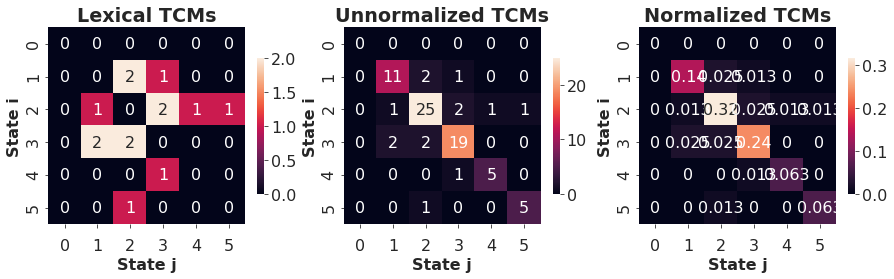

In [11]:
iTrial = 0
fig, axes = plt.subplots(1,3,figsize=(15,5))

K = TPM.shape[-1]
#Create masks for diagonal
diag_mask = np.ones((K,K),dtype=bool)
diag_mask[np.diag_indices(K)] = False

ax = axes[0]
sns.heatmap(lexical_TCMs[iTrial],ax=ax,annot=True,square=True,cbar_kws={'shrink':0.5})

ax.set_title('Lexical TCMs')
ax.set_xlabel('State j'); ax.set_ylabel('State i')


ax = axes[1]

sns.heatmap(TCMs_unnormalized[iTrial],ax=ax,annot=True,square=True,cbar_kws={'shrink':0.5})

ax.set_title('Unnormalized TCMs')
ax.set_xlabel('State j'); ax.set_ylabel('State i')

ax = axes[2]
sns.heatmap(TCMs[iTrial],ax=ax,annot=True,square=True,cbar_kws={'shrink':0.5})

ax.set_title('Normalized TCMs')
ax.set_xlabel('State j'); ax.set_ylabel('State i')
    
    


In [12]:
indy_dict = base_df.groupby(['subject','ocular','distance','platform','success']).indices
mouse_IDs = np.unique(base_df['subject'])
distances = np.unique(base_df['distance'])
vision_types = np.unique(base_df['ocular'])

In [ ]:
for mID in mouse_IDs:
    print('\nMouse: {}'.format(mID))
    for d in distances:
        print('\nDistance: {}->'.format(d),end='\t')        

        for p in range(1,4):
            print('\n\tPlatform {} ->'.format(p),end='\t')
            for s in range(3):
                if (mID,'binocular',d,p,s) in indy_dict.keys():
                    nTrials = len(indy_dict[(mID,'binocular',d,p,s)])
                else:
                    nTrials = 0
                print('{}: {:3d} trials'.format(s,nTrials),end='\t')
            

In [211]:
vision_types = np.unique(base_df['ocular'])

In [205]:
indy_dict = base_df.groupby(['subject','ocular','distance','success']).indices
for d in distances:
    print('\nDistance: {}->'.format(d),end='\t')        

    for s in range(3):
        if (mID,'binocular',d,s) in indy_dict.keys():
            nTrials = len(indy_dict[mID,'binocular',d,s])
        else:
            nTrials = 0
        print('{}: {:3d} trials'.format(s,nTrials),end='\t')


Distance: 8->	0:   0 trials	1:  66 trials	2:   0 trials	
Distance: 12->	0:   2 trials	1:  66 trials	2:   0 trials	
Distance: 16->	0:   3 trials	1:  61 trials	2:   0 trials	
Distance: 20->	0:   8 trials	1:  57 trials	2:   0 trials	
Distance: 24->	0:  32 trials	1:  30 trials	2:   2 trials	

In [206]:
indy_dict = base_df.groupby(['subject','ocular','distance','success']).indices
for d in distances:
    print('\nDistance: {}->'.format(d),end='\t')        

    for s in range(3):
        if (mID,'monocular',d,s) in indy_dict.keys():
            nTrials = len(indy_dict[mID,'monocular',d,s])
        else:
            nTrials = 0
        print('{}: {:3d} trials'.format(s,nTrials),end='\t')


Distance: 8->	0:   1 trials	1:  19 trials	2:   0 trials	
Distance: 12->	0:   2 trials	1:  19 trials	2:   0 trials	
Distance: 16->	0:   2 trials	1:  21 trials	2:   0 trials	
Distance: 20->	0:   3 trials	1:  18 trials	2:   0 trials	
Distance: 24->	0:  11 trials	1:  10 trials	2:   0 trials	

In [13]:
mID = 'J158BLT'
dist = 24

indy_dict = base_df.groupby(['subject','ocular','distance','success']).indices

#Get "Failure" trials
indy = indy_dict[(mID,'binocular',dist,0)]
nTrials_0 = len(indy)
failure_TCMs = TCMs[indy].reshape(nTrials_0,-1)

#Get "Success" trials
indy = indy_dict[(mID,'binocular',dist,1)]
nTrials_1 = len(indy)
success_TCMs = TCMs[indy].reshape(nTrials_1,-1)

nTrials_match = np.min([nTrials_0,nTrials_1])
print(f'{nTrials_match} trials matched')
trial_indices = np.concatenate((indy_dict[(mID,'binocular',dist,0)][:nTrials_match],indy_dict[(mID,'binocular',dist,1)][:nTrials_match]))

30 trials matched


In [14]:
##===== Put in form for decoding analysis =====##
X = np.vstack((failure_TCMs[:nTrials_match],success_TCMs[:nTrials_match]))
Y = np.concatenate((np.repeat(0,nTrials_match),np.repeat(1,nTrials_match)))

Y_sort = ['{}_{}'.format(base_df.iloc[iT]['platform'],base_df.iloc[iT]['success']) for iT in trial_indices]


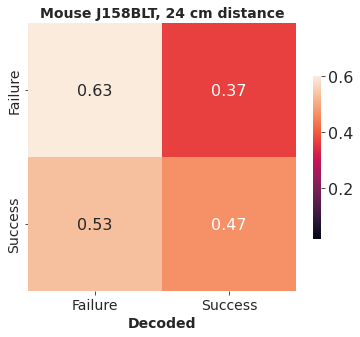

In [15]:
classifier = 'LDA'
method='kfold'

## Try to decode whether the animal was successful or not based on the transition count matrices
confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X,Y,Y_sort,clabels=[0,1],nKfold=5,classifier=classifier,method=method)

#Plot decoding performance 
title = 'Mouse {}, {} cm distance'.format(mID,dist)
dc.plot_decoding_accuracy(confusion_mat,confusion_z,class_labels=['Failure','Success'],title=title)

In [16]:
indy_dict = base_df.groupby(['ocular','distance','success']).indices
vt = 'binocular'
for d in distances:
    print('\nDistance: {}->'.format(d),end='\t')        

    for s in range(3):
        if (vt,d,s) in indy_dict.keys():
            nTrials = len(indy_dict[vt,d,s])
        else:
            nTrials = 0
        print('{}: {:3d} trials'.format(s,nTrials),end='\t')


Distance: 8->	0:   3 trials	1: 568 trials	2:   7 trials	
Distance: 12->	0:  16 trials	1: 583 trials	2:  11 trials	
Distance: 16->	0:  30 trials	1: 539 trials	2:  29 trials	
Distance: 20->	0:  97 trials	1: 441 trials	2:  49 trials	
Distance: 24->	0: 288 trials	1: 198 trials	2: 112 trials	

In [ ]:
    #Create predictors and labels
    X = TCMs[trial_indices].reshape(len(trial_indices),-1)
    Y = np.array(base_df.iloc[trial_indices]['ocular'])
    Y_sort = np.array(['{}_{}_{}'.format(base_df.iloc[iT]['ocular'],base_df.iloc[iT]['platform'],base_df.iloc[iT]['distance']) for iT in trial_indices])
#         print(np.unique(Y_sort,return_counts=True))
    _,nTrials_match = np.unique(Y,return_counts=True)

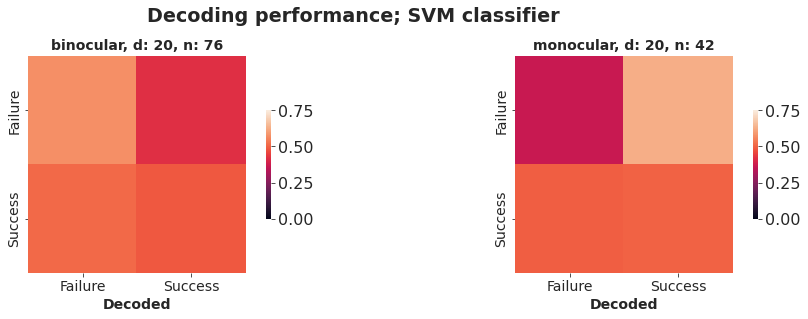

In [26]:
## Lump together trials from different mice

classifier = 'SVM'
method='kfold'

d = distances[-2]


fig, axes = plt.subplots(1,2,figsize=(16,4))
plt.suptitle('Decoding performance; {} classifier'.format(classifier),y=1.05)
for ii, vt in enumerate(vision_types):

    ##Can we decode failure vs success trials within the same mouse/distance?
    indy_dict = base_df.groupby(['subject','ocular','distance','platform','success']).indices

    #What is the minimum # of trials between these conditions
    #Get trial indices
    indy_list = []
    for mID in mouse_IDs:
        for p in range(1,4):
            if ((mID,vt,d,p,0) not in indy_dict.keys()) | ((mID,vt,d,p,1) not in indy_dict.keys()):
                continue
            #match # of trials within subgroups
            nTrials_match = np.min([len(indy_dict[(mID,vt,d,p,s)]) for s in range(2)])
            for s in range(2):
                indy_tmp = indy_dict[(mID,vt,d,p,s)].copy()
                #Take random subset of trials to match # of nTrials_match
                np.random.shuffle(indy_tmp)
                indy_list.append(indy_tmp[:nTrials_match])
    trial_indices = np.concatenate(indy_list)

    #Create predictors and labels
    X = TCMs[trial_indices].reshape(len(trial_indices),-1)
    Y = np.array(base_df.iloc[trial_indices]['success'])
    Y_sort = []
    Y_sort = np.array(['{}_{}_{}'.format(base_df.iloc[iT]['subject'],base_df.iloc[iT]['success'],base_df.iloc[iT]['platform']) for iT in trial_indices])
    _,nTrials_match = np.unique(Y,return_counts=True)
    

    # decoding analysis
    confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X,Y,Y_sort,clabels=np.arange(2),nKfold=5,classifier=classifier,method=method)

    #Plot decoding performance 
    title = '{}, d: {}, n: {}'.format(vt,d,nTrials_match[0])
    dc.plot_decoding_accuracy(confusion_mat,confusion_z,class_labels=['Failure','Success'],ax=axes[ii],title=title,annot=False,clims=[0,0.75])

plt.savefig('./plots/decoding/btwperformance_mousecombined_dist-{}_{}.png'.format(d,classifier))
#     pdb.set_trace()

In [ ]:
classifier = 'SVM'
method='L1O'

mID = mouseIDs[-1]
s = 1
d = distances[-1]
for ii, mID in enumerate(mouseIDs):

    fig, axes = plt.subplots(1,2,figsize=(16,4))
    plt.suptitle('Decoding performance for mouse {}; {} classifier'.format(mID,classifier))
    for ii, vt in enumerate(vision_types):
#         for jj, d in enumerate(distances[-2:]):
        ##Can we decode failure vs success trials within the same mouse/distance?
        indy_dict = base_df.groupby(['subject','ocular','distance','success']).indices

        #What is the minimum # of trials between these conditions
        nTrials_match = np.min([len(indy_dict[(mID,vt,d,s)]) for s in range(2)])
        print(f'{nTrials_match} trials matched')
        if nTrials_match < 10:
            axes[ii].axis('off')
            continue
        #Get trial indices
        indy_list = []
        for s in range(2):
            indy_tmp = indy_dict[(mID,vt,d,s)].copy()
            #Take random subset of trials to match # of nTrials_match
            np.random.shuffle(indy_tmp)
            indy_list.append(indy_tmp[:nTrials_match])
        trial_indices = np.concatenate(indy_list)

        #Create predictors and labels
        X = TCMs[trial_indices].reshape(len(trial_indices),-1)
        Y = np.array(base_df.iloc[trial_indices]['success'])
        Y_sort = np.array(['{}_{}'.format(base_df.iloc[iT]['success'],base_df.iloc[iT]['platform']) for iT in trial_indices])
#         print(np.unique(Y_sort,return_counts=True))
        # decoding analysis
        confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X,Y,Y_sort,clabels=np.arange(2),nKfold=5,classifier=classifier,method=method)

        #Plot decoding performance 
        title = '{}, d: {}, n: {}'.format(vt,d,nTrials_match)
        dc.plot_decoding_accuracy(confusion_mat,confusion_z,class_labels=np.arange(2),ax=axes[ii],title=title,annot=False,clims=[0,0.75])

    plt.savefig('./plots/decoding/btwperformance_{}_{}.png'.format(mID,classifier))
#     pdb.set_trace()

In [ ]:
 / data lexical_TCMs, TCMs, TCMs_unnormalized

In [109]:
mouse_IDs[-1]

'PV-CHR11P2RT'

17 trials matched
19 trials matched
12 trials matched
15 trials matched
29 trials matched
29 trials matched
36 trials matched
30 trials matched
19 trials matched
19 trials matched
21 trials matched
18 trials matched
28 trials matched
25 trials matched
19 trials matched
22 trials matched
29 trials matched
28 trials matched
30 trials matched
19 trials matched
28 trials matched
27 trials matched
27 trials matched
19 trials matched
22 trials matched
23 trials matched
20 trials matched
14 trials matched
24 trials matched
22 trials matched
29 trials matched
20 trials matched


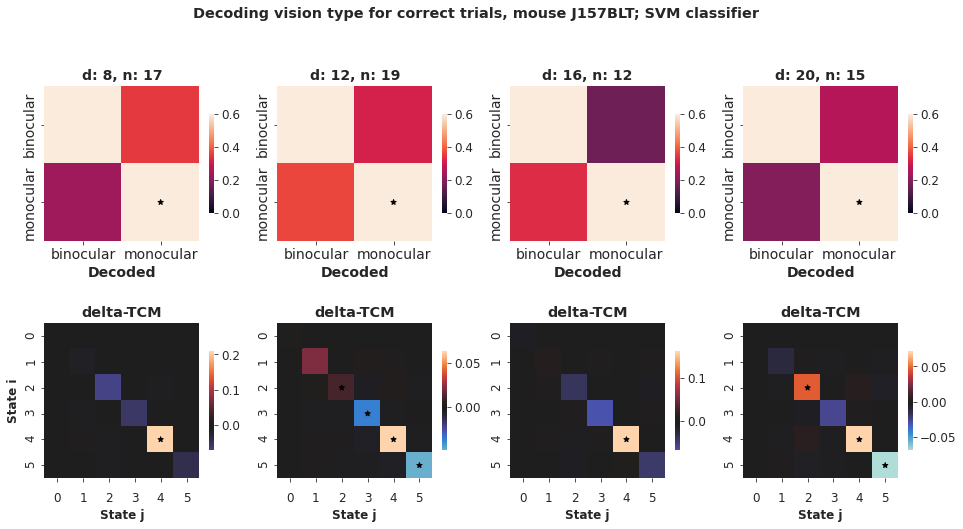

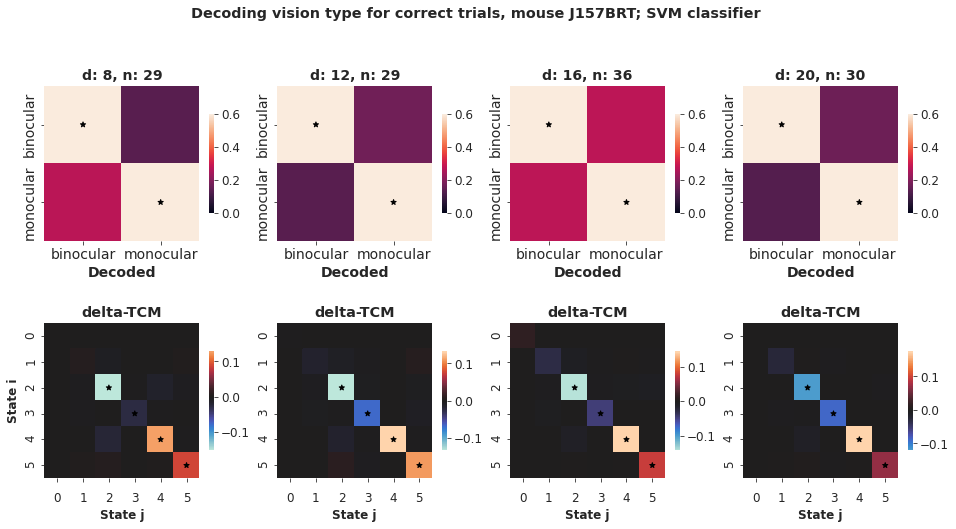

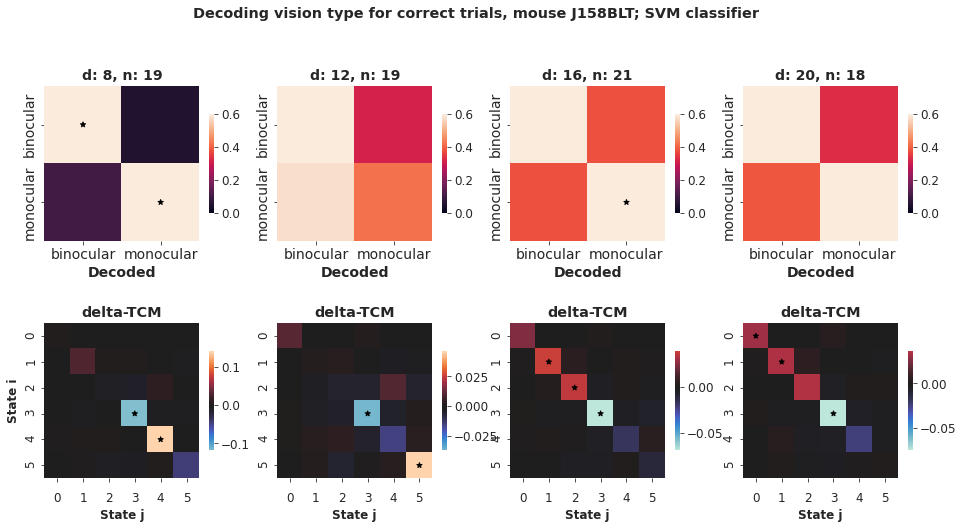

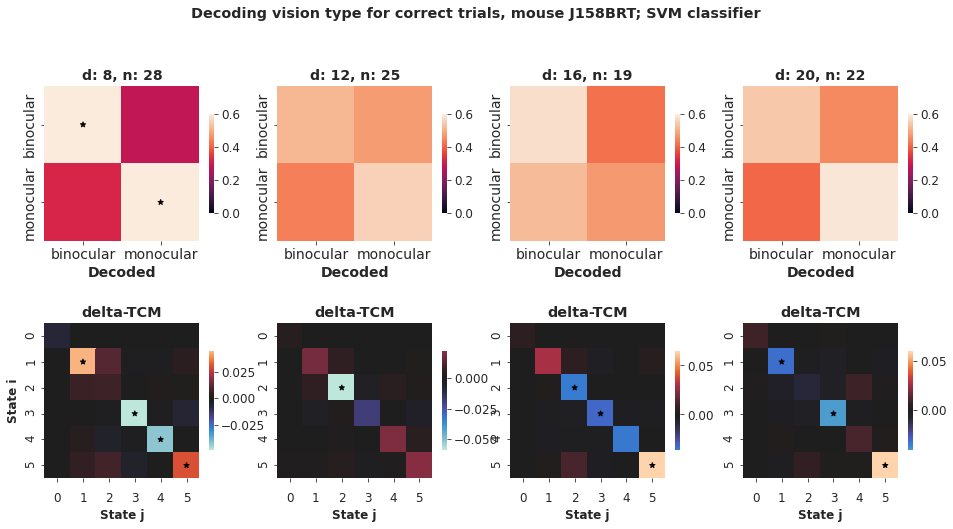

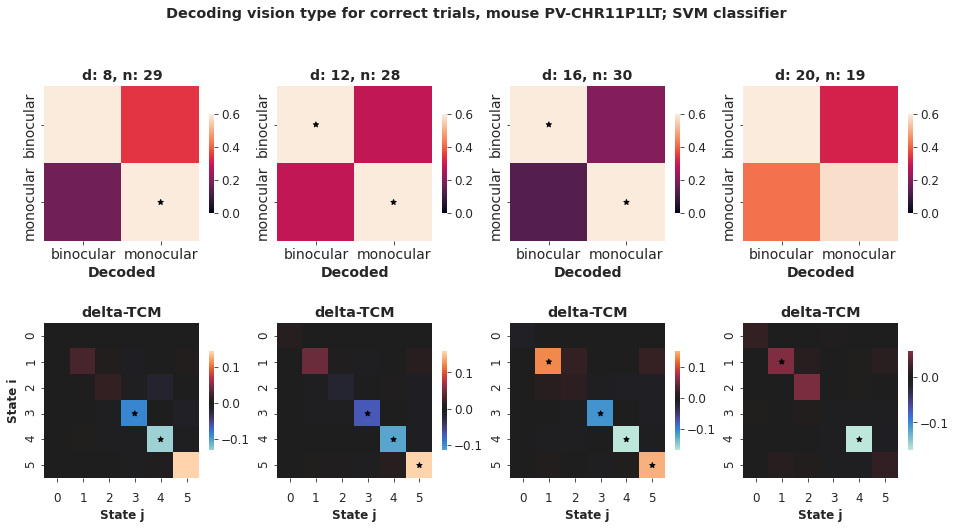

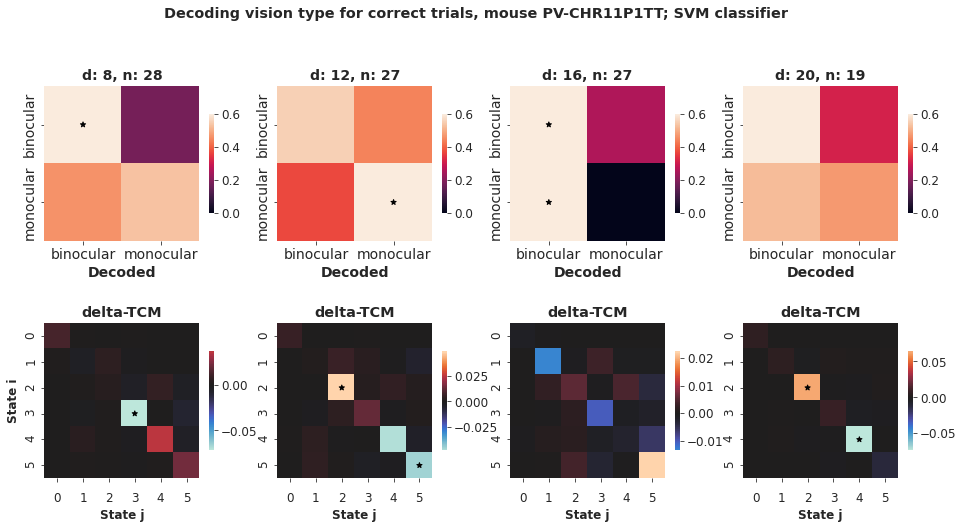

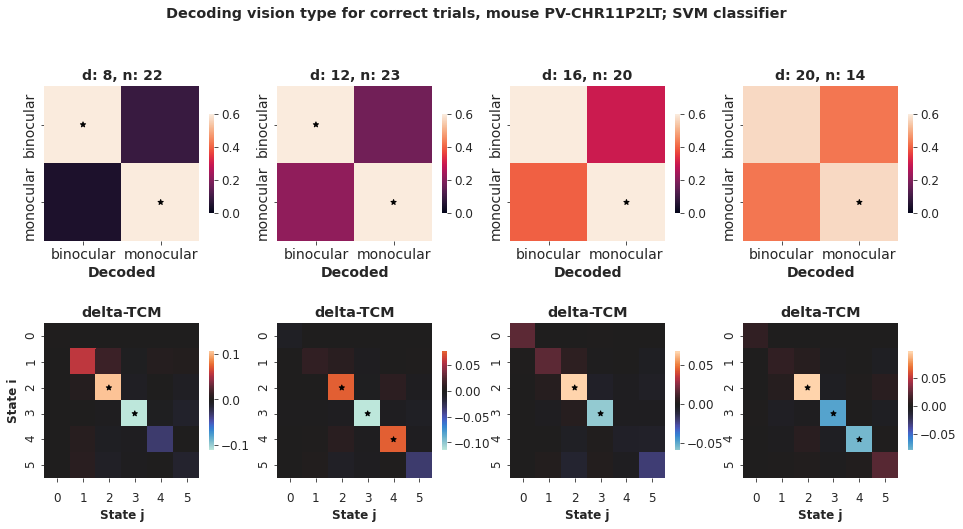

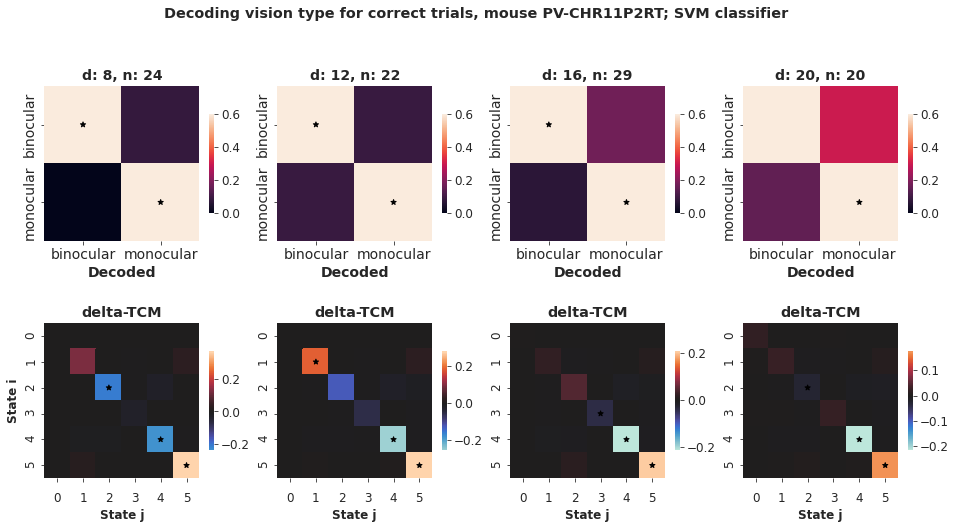

In [108]:
classifier = 'SVM'
method='L1O'

mID = mouse_IDs[-1]
s = 1

for ii, mID in enumerate(mouse_IDs):

    fig, axes = plt.subplots(2,4,figsize=(16,8))
    plt.suptitle('Decoding vision type for correct trials, mouse {}; {} classifier'.format(mID,classifier))
    for ii, d in enumerate(distances[:-1]):
        ##Can we decode monocular vs binocular success trials within the same mouse/distance?
        indy_dict = base_df.groupby(['subject','ocular','distance','success']).indices

        #What is the minimum # of trials between these conditions
        nTrials_match = np.min([len(indy_dict[(mID,v,d,1)]) for v in vision_types])
        print(f'{nTrials_match} trials matched')

        #Get trial indices
        indy_list = []
        for v in vision_types:
            indy_tmp = indy_dict[(mID,v,d,1)].copy()
            #Take random subset of trials to match # of nTrials_match
            np.random.shuffle(indy_tmp)
            indy_list.append(indy_tmp[:nTrials_match])
        trial_indices = np.concatenate(indy_list)

        #Create predictors and labels
        X = TCMs[trial_indices].reshape(len(trial_indices),-1)
        Y = np.array(base_df.iloc[trial_indices]['ocular'])
        Y_sort = np.array(['{}_{}'.format(base_df.iloc[iT]['ocular'],base_df.iloc[iT]['platform']) for iT in trial_indices])
#         print(np.unique(Y_sort,return_counts=True))
        # decoding analysis
        confusion_mat, confusion_shf, confusion_z, decoding_weights, decoding_weights_shf, decoding_weights_z = dc.cross_validate(X,Y,Y_sort,clabels=vision_types,nKfold=5,classifier=classifier,method=method)

        nModels = decoding_weights_z.shape[0]
        features = np.zeros((K,K))
        for iM in range(nModels):
            pvalues_loo = st.norm.sf(decoding_weights_z[iM])
            indy = np.where((pvalues_loo < 0.05) | (pvalues_loo > 0.95))
            for x,y in zip(indy[0],indy[1]):
                features[x,y] = 1
        
        #Plot decoding performance 
        title = 'd: {}, n: {}'.format(d,nTrials_match)
        dc.plot_decoding_accuracy(confusion_mat,confusion_z,class_labels=vision_types,ax=axes[0,ii],title=title,annot=False,clims=[0,0.6])
        
        #Plot the delta-TCM that resulted in such a confusion matri
        dX = np.mean(X[np.where(Y == vision_types[0])],axis=0).reshape((K,K)) - np.mean(X[np.where(Y == vision_types[1])],axis=0).reshape((K,K))
        
        ax = axes[1,ii]
        sns.heatmap(dX,ax=ax,annot=False,square=True,cbar_kws={'shrink':0.5},center=0)
        ax.set_title('delta-TCM')
        ax.set_xlabel('State j'); 
        if ii == 0: 
            ax.set_ylabel('State i')
        x = np.linspace(0, features.shape[0]-1, features.shape[0])+0.5
        y = np.linspace(0, features.shape[1]-1, features.shape[1])+0.5
        X, Y = np.meshgrid(x, y)
        ax.scatter(X,Y,marker='*',s=30*features, c='k')
    
    
#     plt.show()
#     pdb.set_trace()
    plt.savefig('./plots/decoding/btwvisiontype_fullTCM_{}_{}_{}.png'.format(mID,success_dict[s],classifier))

In [99]:
X.shape

(38, 36)

In [93]:
features = []
for iM in range(nModels):
    pvalues_loo = st.norm.sf(decoding_weights_z[iM])
    indy = np.where((pvalues_loo < 0.05) | (pvalues_loo > 0.95))
    for x,y in zip(indy[0],indy[1]):
        features.append((x,y))
states_of_interest = list(set(features))
states_of_interest

[(4, 4), (5, 5)]

<AxesSubplot:>

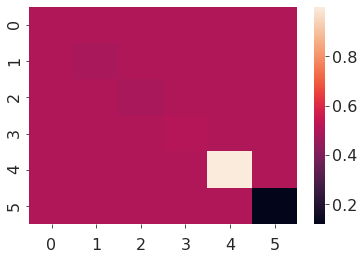

In [75]:
pvalues_loo = st.norm.sf(np.mean(decoding_weights_z,axis=0))
pval_mask = pvalues_loo
sns.heatmap(pvalues_loo,cbar=True)

In [ ]:
np.mean(decoding_weights_z,axis=0)

<AxesSubplot:>

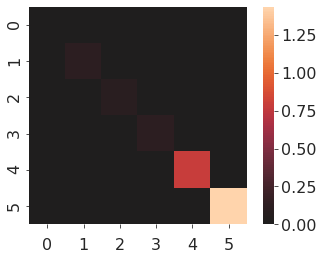

In [77]:
sns.heatmap(np.std(decoding_weights_z,axis=0),square=True,center=0)

In [ ]:
np.mean(decoding_weights_z,axis=0)

<AxesSubplot:>

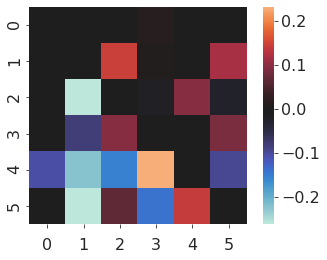

In [64]:
sns.heatmap(np.sum(decoding_weights_shf,axis=0),square=True,center=0)

In [57]:
decoding_weights_shf.shape

(17, 6, 6)

196 trials matched
192 trials matched
194 trials matched
157 trials matched


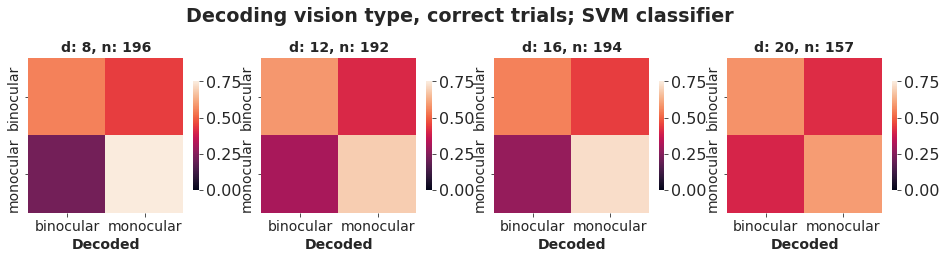

In [38]:
classifier = 'SVM'
method='kfold'

s = 1
p = 1
fig, axes = plt.subplots(1,4,figsize=(16,4))
plt.suptitle('Decoding vision type, {} trials; {} classifier'.format(success_dict[s],classifier),y=0.95)
for ii, d in enumerate(distances[:-1]):


    ##Can we decode monocular vs binocular success trials within the same mouse/distance?
    indy_dict = base_df.groupby(['subject','ocular','distance','platform','success']).indices

    #Get trial indices
    indy_list = []
    for mID in mouse_IDs:
        for p in range(1,4):
            if ((mID,vision_types[0],d,p,s) not in indy_dict.keys()) | ((mID,vision_types[1],d,p,s) not in indy_dict.keys()):
                continue
            nTrials_match = np.min([len(indy_dict[(mID,v,d,p,s)]) for v in vision_types])
            for v in vision_types:
                indy_tmp = indy_dict[(mID,v,d,p,s)].copy()
                #Take random subset of trials to match # of nTrials_match
                np.random.shuffle(indy_tmp)
                indy_list.append(indy_tmp[:nTrials_match])
    trial_indices = np.concatenate(indy_list)
    
    #Create predictors and labels
    X = TCMs[trial_indices].reshape(len(trial_indices),-1)
    Y = np.array(base_df.iloc[trial_indices]['ocular'])
    Y_sort = np.array(['{}_{}_{}'.format(base_df.iloc[iT]['subject'],base_df.iloc[iT]['platform'],base_df.iloc[iT]['ocular']) for iT in trial_indices])
#         print(np.unique(Y_sort,return_counts=True))
    _,nTrials_match = np.unique(Y,return_counts=True)
    print(f'{nTrials_match[0]} trials matched')
#     print(f'{nTrials_match} trials matched')
#     pdb.set_trace()
    # decoding analysis
    confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X,Y,Y_sort,clabels=vision_types,nKfold=5,classifier=classifier,method=method)

    #Plot decoding performance 
    title = 'd: {}, n: {}'.format(d,nTrials_match[0])
    dc.plot_decoding_accuracy(confusion_mat,confusion_z,class_labels=vision_types,ax=axes[ii],title=title,annot=False,clims=[0,0.75])

plt.savefig('./plots/decoding/btwvisiontype_mousecombined_{}_{}.png'.format(success_dict[s],classifier))

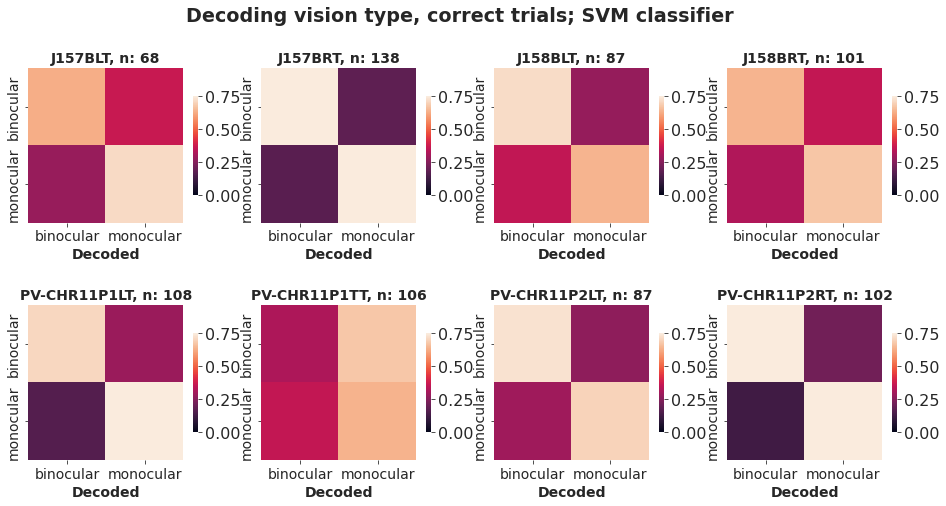

In [33]:
classifier = 'SVM'
method='L1O'

s = 1
p = 1
fig, axes = plt.subplots(2,4,figsize=(16,8))
plt.suptitle('Decoding vision type, {} trials; {} classifier'.format(success_dict[s],classifier),y=0.95)
for ii, mID in enumerate(mouse_IDs):


    ##Can we decode monocular vs binocular success trials within the same mouse/distance?
    indy_dict = base_df.groupby(['subject','ocular','distance','platform','success']).indices

#     #What is the minimum # of trials between these conditions
#     nTrials_match = np.min([len(indy_dict[(mID,v,s)]) for v in vision_types])
#     print([len(indy_dict[(mID,v,s)]) for v in vision_types])
#     print(f'{nTrials_match} trials matched')

    #Get trial indices
    indy_list = []
    for d in distances:
        for p in range(1,4):
            if ((mID,vision_types[0],d,p,s) not in indy_dict.keys()) | ((mID,vision_types[1],d,p,s) not in indy_dict.keys()):
                continue
            nTrials_match = np.min([len(indy_dict[(mID,v,d,p,s)]) for v in vision_types])
            for v in vision_types:
                indy_tmp = indy_dict[(mID,v,d,p,s)].copy()
                #Take random subset of trials to match # of nTrials_match
                np.random.shuffle(indy_tmp)
                indy_list.append(indy_tmp[:nTrials_match])
    trial_indices = np.concatenate(indy_list)
    
    
    #Create predictors and labels
    X = TCMs[trial_indices].reshape(len(trial_indices),-1)
    Y = np.array(base_df.iloc[trial_indices]['ocular'])
    Y_sort = np.array(['{}_{}_{}'.format(base_df.iloc[iT]['ocular'],base_df.iloc[iT]['platform'],base_df.iloc[iT]['distance']) for iT in trial_indices])
#         print(np.unique(Y_sort,return_counts=True))
    _,nTrials_match = np.unique(Y,return_counts=True)
#     print(f'{nTrials_match} trials matched')
#     pdb.set_trace()
    # decoding analysis
    confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X,Y,Y_sort,clabels=vision_types,nKfold=10,classifier=classifier,method=method)

    #Plot decoding performance 
    title = '{}, n: {}'.format(mID,nTrials_match[0])
    dc.plot_decoding_accuracy(confusion_mat,confusion_z,class_labels=vision_types,ax=axes[ii//4,ii%4],title=title,annot=False,clims=[0,0.75])

plt.savefig('./plots/decoding/btwvisiontype_dist-lump_{}_{}.png'.format(success_dict[s],classifier))

In [374]:
[len(indy_dict[(mID,v,d,p,s)]) for v in vision_types]

KeyError: ('PV-CHR11P1LT', 'monocular', 24, 2, 1)

In [365]:
Y_sort

array(['binocular_1_8', 'binocular_1_8', 'binocular_1_8', 'binocular_1_8',
       'binocular_1_8', 'binocular_1_8', 'binocular_1_8', 'monocular_1_8',
       'monocular_1_8', 'monocular_1_8', 'monocular_1_8', 'monocular_1_8',
       'monocular_1_8', 'monocular_1_8', 'binocular_2_8', 'binocular_2_8',
       'binocular_2_8', 'binocular_2_8', 'binocular_2_8', 'monocular_2_8',
       'monocular_2_8', 'monocular_2_8', 'monocular_2_8', 'monocular_2_8',
       'binocular_3_8', 'binocular_3_8', 'binocular_3_8', 'binocular_3_8',
       'binocular_3_8', 'monocular_3_8', 'monocular_3_8', 'monocular_3_8',
       'monocular_3_8', 'monocular_3_8', 'binocular_1_12',
       'binocular_1_12', 'binocular_1_12', 'binocular_1_12',
       'binocular_1_12', 'monocular_1_12', 'monocular_1_12',
       'monocular_1_12', 'monocular_1_12', 'monocular_1_12',
       'binocular_2_12', 'binocular_2_12', 'binocular_2_12',
       'binocular_2_12', 'binocular_2_12', 'binocular_2_12',
       'binocular_2_12', 'binocular_

In [369]:
    for d in distances:
        for p in range(1,4):
            n1 = len(np.where(Y_sort == f'binocular_{p}_{d}')[0])
            n2 = len(np.where(Y_sort == f'monocular_{p}_{d}')[0])
            print(f'{n1}/{n2}')

7/7
5/5
5/5
5/5
8/8
6/6
3/3
3/3
6/6
5/5
3/3
7/7
3/3
1/1
1/1


In [271]:
indy_dict = base_df.groupby(['subject','ocular','distance','platform','success']).indices
[len(indy_dict[(mID,'binocular',distances[-1],p,1)]) for p in range(1,4)]

[14, 8, 8]

In [352]:
mouse_IDs

array(['J157BLT', 'J157BRT', 'J158BLT', 'J158BRT', 'PV-CHR11P1LT',
       'PV-CHR11P1TT', 'PV-CHR11P2LT', 'PV-CHR11P2RT'], dtype=object)

12 trials matched
19 trials matched
20 trials matched
20 trials matched
25 trials matched
26 trials matched
24 trials matched
33 trials matched
10 trials matched
21 trials matched
21 trials matched
19 trials matched
26 trials matched
24 trials matched
25 trials matched
34 trials matched
8 trials matched
20 trials matched
19 trials matched
19 trials matched
25 trials matched
22 trials matched
17 trials matched
34 trials matched
8 trials matched
16 trials matched
18 trials matched
16 trials matched
23 trials matched
6 trials matched
12 trials matched
26 trials matched
1 trials matched
8 trials matched
8 trials matched
9 trials matched
3 trials matched
2 trials matched
5 trials matched
3 trials matched


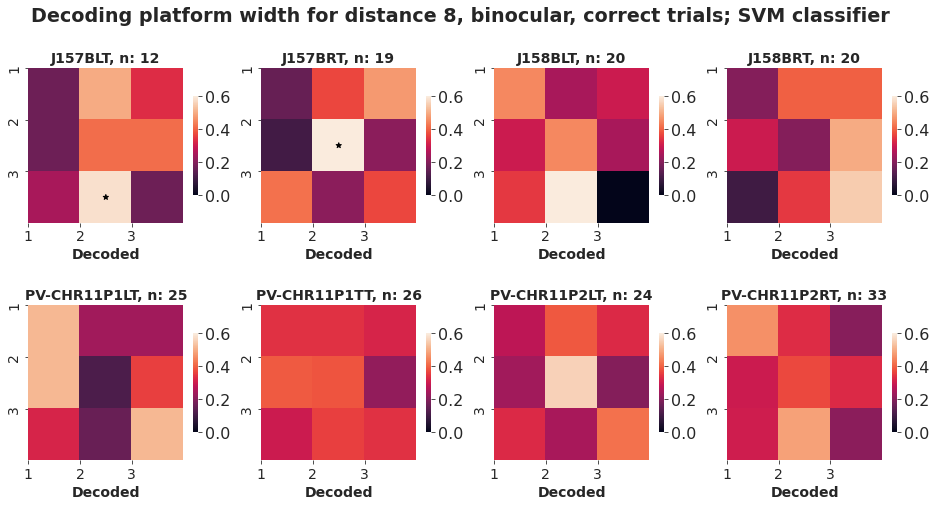

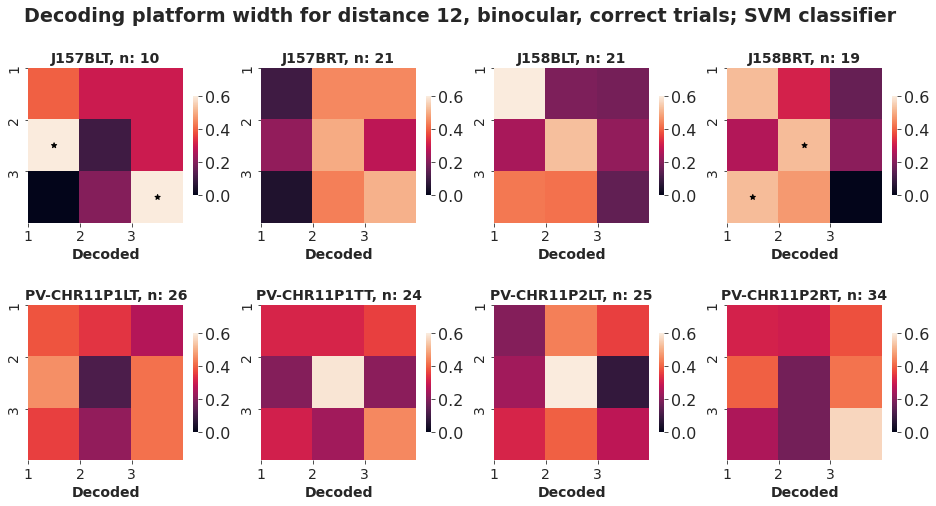

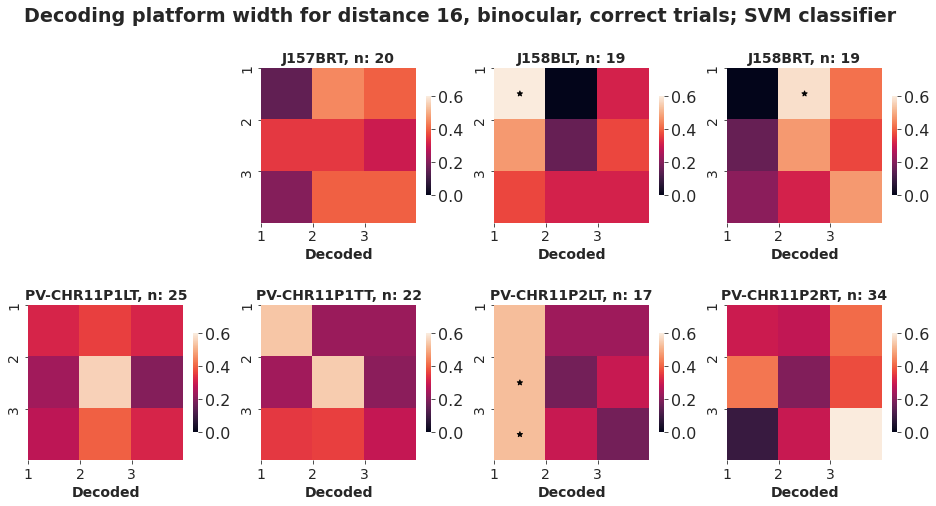

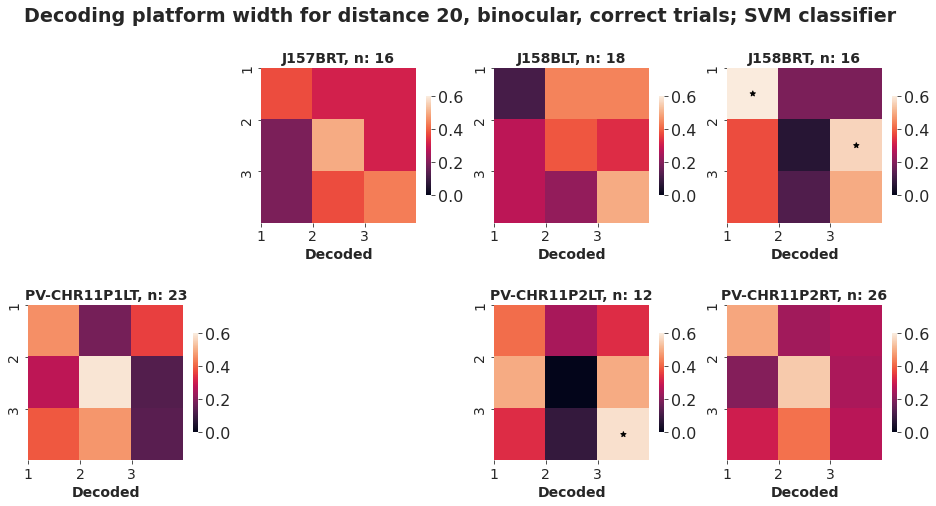

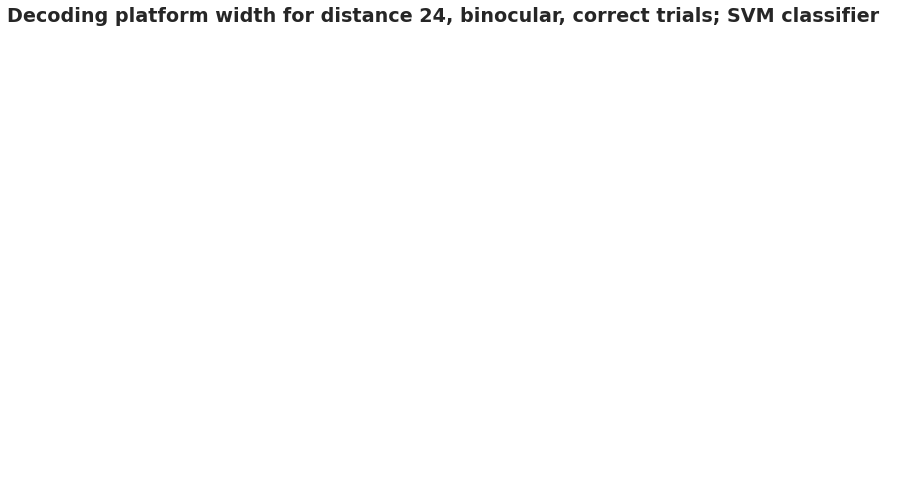

In [351]:
classifier = 'SVM'
s = 1
vt = 'binocular'
d = distances[0]

for d in distances:
    fig, axes = plt.subplots(2,4,figsize=(16,8))
    plt.suptitle('Decoding platform width for distance {}, {}, {} trials; {} classifier'.format(d,vt,success_dict[s],classifier),y=0.95)

    for ii, mID in enumerate(mouseIDs):
        ##Can we decode different distances successfully jumped within the same mouse?
        indy_dict = base_df.groupby(['subject','ocular','distance','platform','success']).indices
        nTrials_match = np.min([len(indy_dict[(mID,vt,d,p,s)]) for p in range(1,4)])
        print(f'{nTrials_match} trials matched')

        indy_list = []
        for p in range(1,4):
            indy_list.append(indy_dict[(mID,vt,d,p,s)][:nTrials_match])
        trial_indices = np.concatenate(indy_list)

        X = TCMs[trial_indices].reshape(len(trial_indices),-1)
        Y = np.array(base_df.iloc[trial_indices]['platform'])
    #     Y_sort = ['{}_{}'.format(base_df.iloc[iT]['distance'],base_df.iloc[iT]['platform']) for iT in trial_indices]

        if nTrials_match < 10:
            axes[ii//4,ii%4].axis('off')
            continue
        if nTrials_match < 20:
            method='L1O'
            Y_sort = Y
        else:
            method='kfold'

        ## Try to decode whether the animal was successful or not based on the transition count matrices
        confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X,Y,clabels=np.arange(1,4),nKfold=5,classifier=classifier,method=method)

        #Plot decoding performance 
        title = '{}, n: {}'.format(mID,nTrials_match)
        dc.plot_decoding_accuracy(confusion_mat,confusion_z,class_labels=np.arange(1,4),ax=axes[ii//4,ii%4],title=title,annot=False,clims=[0,0.6])
    plt.savefig('./plots/decoding/btwplatformwidth_dist-{}_{}_{}_{}.png'.format(d,vt,success_dict[s],classifier))

27 trials matched
54 trials matched
57 trials matched
50 trials matched
75 trials matched
33 trials matched
58 trials matched
87 trials matched


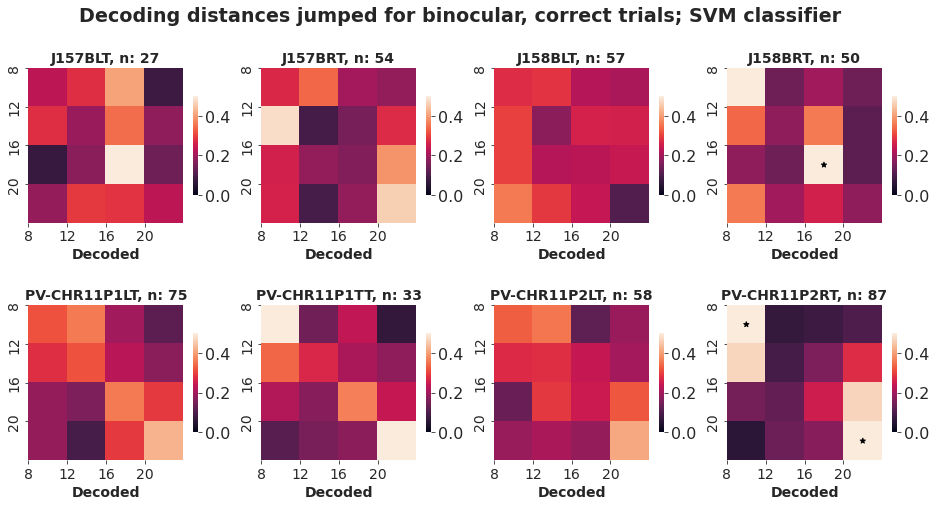

In [338]:
classifier = 'SVM'
s = 1
vt = 'binocular'
fig, axes = plt.subplots(2,4,figsize=(16,8))
plt.suptitle('Decoding distances jumped for {}, {} trials; {} classifier'.format(vt,success_dict[s],classifier),y=0.95)

for ii, mID in enumerate(mouseIDs):
    ##Can we decode different distances successfully jumped within the same mouse?
    indy_dict = base_df.groupby(['subject','ocular','distance','success']).indices
    nTrials_match = np.min([len(indy_dict[(mID,vt,d,s)]) for d in distances[:-1]])
    print(f'{nTrials_match} trials matched')

    indy_list = []
    for d in distances[:-1]:
        indy_list.append(indy_dict[(mID,'binocular',d,1)][:nTrials_match])
    trial_indices = np.concatenate(indy_list)

    X = TCMs[trial_indices].reshape(len(trial_indices),-1)
    Y = np.array(base_df.iloc[trial_indices]['distance'])
    Y_sort = ['{}_{}'.format(base_df.iloc[iT]['distance'],base_df.iloc[iT]['platform']) for iT in trial_indices]

    if nTrials_match < 20:
        method='L1O'
        Y_sort = Y
    else:
        method='kfold'

    ## Try to decode whether the animal was successful or not based on the transition count matrices
    confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X,Y,Y_sort,clabels=distances[:-1],nKfold=5,classifier=classifier,method=method)

    #Plot decoding performance 
    title = '{}, n: {}'.format(mID,nTrials_match)
    dc.plot_decoding_accuracy(confusion_mat,confusion_z,class_labels=distances[:-1],ax=axes[ii//4,ii%4],title=title,annot=False,clims=[0,0.5])
plt.savefig('./plots/decoding/btwdistances_{}_{}_{}.png'.format(vt,success_dict[s],classifier))

40 trials matched
35 trials matched
30 trials matched
27 trials matched


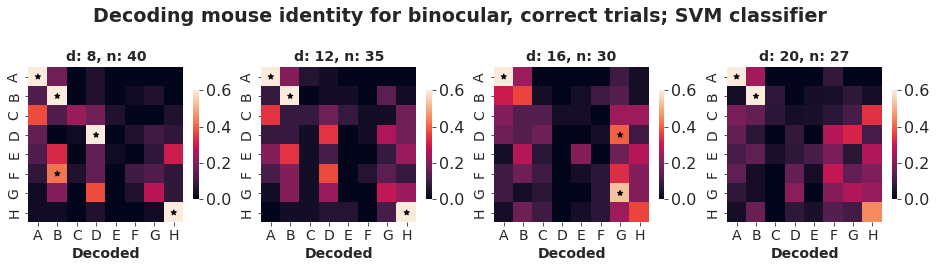

In [114]:
d = distances[-1]
classifier = 'SVM'
s = 1
vt = 'binocular'
fig, axes = plt.subplots(1,4,figsize=(16,4))
plt.suptitle('Decoding mouse identity for binocular, correct trials; {} classifier'.format(classifier))
for ii, d in enumerate(distances[:-1]):

    ##Can we decode different mice within the same distance
    indy_dict = base_df.groupby(['subject','ocular','distance','success']).indices
    nTrials_match = np.min([len(indy_dict[(mID,vt,d,s)]) for mID in mouse_IDs])
    print(f'{nTrials_match} trials matched')

    indy_list = []
    for mID in mouse_IDs:
        indy_list.append(indy_dict[(mID,vt,d,1)][:nTrials_match])
    trial_indices = np.concatenate(indy_list)

    X = TCMs[trial_indices].reshape(len(trial_indices),-1)
    Y = np.array(base_df.iloc[trial_indices]['subject'])
    Y_sort = ['{}_{}'.format(base_df.iloc[iT]['subject'],base_df.iloc[iT]['platform']) for iT in trial_indices]

    if nTrials_match < 20:
        method='L1O'
    else:
        method='kfold'

    ## Try to decode whether the animal was successful or not based on the transition count matrices
    confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X,Y,Y_sort,clabels=mouse_IDs,nKfold=5,classifier=classifier,method=method)

    #Plot decoding performance 
    title = 'd: {}, n: {}'.format(d,nTrials_match)
    dc.plot_decoding_accuracy(confusion_mat,confusion_z,class_labels=['A','B','C','D','E','F','G','H'],title=title,ax=axes[ii],annot=False,clims=[0,0.6])
    if ii == 0:
        ax.set_ylabel('Actual',fontsize=14)
plt.savefig('./plots/decoding/btwmice_{}_{}_{}.png'.format(vt,success_dict[s],classifier))